С помощью векторных представлений слов

Используем векторные представления Navec.

In [171]:
!pip install navec

In [172]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.metrics import f1_score, accuracy_score
import sklearn
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

In [173]:
emoji_dict = {"0":"smile positive/negative", "1":"no_emotion neutral/skeptical", "2":"joy positive",
              "3":"no_emotion positive/negative", "4":"sadness negative", "5":"fear negative",
              "6":"shame negative","7":"anger negative", "8":"disgust negative",
              "9":"surprise positive/negative","10":"disgust neutral/skeptical", "11":"surprise negative",
              "12":"no_emotion negative","13":"sadness positive/negative", "14":"fear positive/negative"}

In [174]:
emoji_dict["13"]

'sadness positive/negative'

## Загружаем и готовим набор данных

In [2]:
df_em_1_token_10 = pd.read_csv('df_em_1_token_10.csv', sep=";")

In [3]:
df_em_1_token_10

,img_emoji,word_count,count_emoji,emotion,tonality,class,clean_text
0,😂,5,1,smile,positive/negative,0,почему бы и нет 😂
1,😁,5,1,smile,positive/negative,0,как сесть на диету 😁
2,😁,6,1,smile,positive/negative,0,когда в душе ещё щенок 😁
3,😻,6,1,joy,positive,2,новые фотографии нюши просто огненные😻
4,😍,7,1,joy,positive,2,безумно красивая актриса - алина ланина 😍
...,...,...,...,...,...,...,...
9215,😄,5,1,smile,positive/negative,0,ряды эскортниц скоро пополнится 😄
9216,😂,7,1,smile,positive/negative,0,так он прав ты реально даун 😂
9217,🤔,7,1,no_emotion,neutral/skeptical,1,вы же не про меня?🤔
9218,🤔,9,1,no_emotion,neutral/skeptical,1,про кого пошутил то это не до комик🤔


In [4]:
df_em_1_token_10.sort_values(by='word_count', ascending=False)

,img_emoji,word_count,count_emoji,emotion,tonality,class,clean_text
5203,😁,11,1,smile,positive/negative,0,"я пользуюсь, но не смотрю.. смотрю мультики и ..."
8441,🤔,11,1,no_emotion,neutral/skeptical,1,так бывает дружба между мужчиной и женщиной ил...
8084,🤣,11,1,smile,positive/negative,0,зачем вам девушка? вам и с голубем не плохо 🤣
8081,😁,11,1,smile,positive/negative,0,ну девок много а я у мамы один такой прекрасный 😁
5467,😁,11,1,smile,positive/negative,0,это когда резко приуныл а тут и страхов очка е...
...,...,...,...,...,...,...,...
7141,😃,2,1,smile,positive/negative,0,круто😃
5010,😉,2,1,smile,positive/negative,0,ага😉
8606,🙂,2,1,smile,positive/negative,0,батя🙂
7126,😂,2,1,smile,positive/negative,0,фотошоп😂


In [6]:
df_em_1_token_10.groupby('word_count').count()

,img_emoji,count_emoji,emotion,tonality,class,clean_text
word_count,,,,,,
2,551,551,551,551,551,551
3,942,942,942,942,942,942
4,1076,1076,1076,1076,1076,1076
5,1127,1127,1127,1127,1127,1127
6,1216,1216,1216,1216,1216,1216
7,1089,1089,1089,1089,1089,1089
8,986,986,986,986,986,986
9,879,879,879,879,879,879
10,749,749,749,749,749,749


Константы

In [12]:
random_state = 42
#max_len = 100
max_len = 11
vector_size = 300

In [10]:
#берём текст как есть с пунктуацией и с эмодзи
def preprocess(text):
    tokens = text.lower().split()
    preprocessed_text = []
    for token in tokens:
        preprocessed_text.append(token)
    return preprocessed_text

In [96]:
import re

In [97]:
#без пунктуации и эмодзи
def preprocess_no_punct(text):
    no_punct_text = re.sub(r'[^\w\s]', ' ', text)
    tokens = no_punct_text.lower().split()
    preprocessed_text = []
    for token in tokens:
        preprocessed_text.append(token)
    return preprocessed_text

In [180]:
import pymorphy2

In [181]:
morph = pymorphy2.MorphAnalyzer()

In [182]:
#леммы без пунктуации и эмодзи
def preprocess_lemma(text):
    no_punct_text = re.sub(r'[^\w\s]', ' ', text)
    tokens = no_punct_text.lower().split()
    preprocessed_text = []
    for token in tokens:
        lemma = morph.parse(token)[0].normal_form
        preprocessed_text.append(lemma)
    return preprocessed_text

In [183]:
#леммы c пунктуацией и эмодзи
def preprocess_lemma_em(text):
    tokens = text.lower().split()
    preprocessed_text = []
    for token in tokens:
        lemma = morph.parse(token)[0].normal_form
        preprocessed_text.append(lemma)
    return preprocessed_text

In [98]:
#df_em_1_token_10['Preprocessed_texts'] = df_em_1_token_10.apply(lambda row: preprocess(row['clean_text']), axis=1)

In [184]:
#df_em_1_token_10['Preprocessed_texts_no_punct'] = df_em_1_token_10.apply(lambda row: preprocess_no_punct(row['clean_text']), axis=1)

In [185]:
df_em_1_token_10['Preprocessed_texts_lemma'] = df_em_1_token_10.apply(lambda row: preprocess_lemma_em(row['clean_text']), axis=1)

## Загружаем предварительно обученные векторы Navec

Библиотека Navec — часть проекта Natasha, коллекция предобученных плотных векторных представлений слов для русского языка. Качество решения сравнимо или выше, чем у статических моделей от RusVectores, размер в 5–6 раз меньше.

In [187]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar -O navec_hudlit_v1_12B_500K_300d_100q.tar

--2023-05-01 13:06:00--  https://storage.yandexcloud.net/natasha-navec/packs/navec_hudlit_v1_12B_500K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53012480 (51M) [application/x-tar]
Saving to: 'navec_hudlit_v1_12B_500K_300d_100q.tar'

navec_hudlit_v1_12B 100%[===================>]  50.56M  7.12MB/s    in 10s     

2023-05-01 13:06:11 (4.98 MB/s) - 'navec_hudlit_v1_12B_500K_300d_100q.tar' saved [53012480/53012480]



In [188]:
from navec import Navec

In [189]:
navec = Navec.load('navec_hudlit_v1_12B_500K_300d_100q.tar')

## Векторизуем текст

Функция для векторизации текста

In [190]:
def vectorize_text(txt, navec, max_len):
    unk = navec['<unk>']
    text_embeddings = []
    for token in txt:
        embedding = navec.get(token, unk)
        text_embeddings.append(embedding)
    # Дополняем или обрезаем текст для фиксированной длины max_len 
    l = len(text_embeddings)
    if l > max_len:
        text_embeddings = text_embeddings[:max_len]
    else:
        text_embeddings.extend([navec['<pad>']] * (max_len - l)) 
    return text_embeddings

Применяем функцию векторизации текста

In [105]:
#df_em_1_token_10['Embeddings'] = df_em_1_token_10.apply(lambda row: vectorize_text(row['Preprocessed_texts'], navec, max_len), axis=1)

In [191]:
#df_em_1_token_10['Embeddings'] = df_em_1_token_10.apply(lambda row: vectorize_text(row['Preprocessed_texts_no_punct'], navec, max_len), axis=1)

In [192]:
df_em_1_token_10['Embeddings'] = df_em_1_token_10.apply(lambda row: vectorize_text(row['Preprocessed_texts_lemma'], navec, max_len), axis=1)

## Готовим данные для обучения

### Выделяем данные для обучения и тестирования

In [13]:
train, test = train_test_split(df_em_1_token_10, test_size=0.2, random_state = random_state)

In [17]:
len(train)+len(test)

9220

### Разделяем метки классов и данные для обучения

Данные для обучения

In [198]:
import numpy as np

In [199]:
x_train = np.array(train['Embeddings'].tolist()).reshape(len(train), vector_size * max_len)
y_train = train['class']

In [200]:
x_train.shape

(7376, 3300)

In [201]:
y_train

5559    0
8376    0
5562    0
1491    0
6375    1
       ..
5734    0
5191    0
5390    4
860     9
7270    0
Name: class, Length: 7376, dtype: int64

Данные для тестирования

In [202]:
x_test = np.array(test['Embeddings'].tolist()).reshape(len(test), vector_size * max_len)
y_test = test['class']

In [203]:
x_test.shape

(1844, 3300)

In [204]:
y_test

7810    0
1180    0
5865    2
623     0
711     5
       ..
4401    0
7481    0
4467    4
4539    0
1323    2
Name: class, Length: 1844, dtype: int64

## Создаем модели машинного обучения

In [205]:
def train_test(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    f1_macro = f1_score(y_test, clf.predict(X_test), average='macro')
    f1_micro = f1_score(y_test, clf.predict(X_test), average='micro')
    f1_weighted = f1_score(y_test, clf.predict(X_test), average='weighted')
    return train_acc, test_acc, f1_macro, f1_micro, f1_weighted

In [206]:
lr = LogisticRegression(random_state=random_state, max_iter=500)
svc = SVC(probability=True)
rforest = RandomForestClassifier(random_state=random_state)
dtree = DecisionTreeClassifier()
nb = GaussianNB()
gb = GradientBoostingClassifier(random_state=random_state)

In [207]:
clifs = [lr, svc, rforest, dtree, nb, gb]

# Ансамблевые методы

## Мажоритарное голосование

In [208]:
from sklearn.ensemble import VotingClassifier

In [209]:
eclf_hard = VotingClassifier(estimators=[('lr', lr), ('svc', svc), ('rforest', rforest), ('dtree', dtree), ('nb', nb), ('gb', gb)], voting='hard')

In [210]:
eclf_hard.fit(x_train, y_train)

/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=500,
                                                 random_state=42)),
                             ('svc', SVC(probability=True)),
                             ('rforest',
                              RandomForestClassifier(random_state=42)),
                             ('dtree', DecisionTreeClassifier()),
                             ('nb', GaussianNB()),
                             ('gb',
                              GradientBoostingClassifier(random_state=42))])

In [211]:
predicted = eclf_hard.predict(x_test)

In [39]:
#Preprocessed_texts

In [40]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.64      0.99      0.78      1166
           1       1.00      0.00      0.01       203
           2       0.65      0.07      0.13       152
           3       0.40      0.02      0.04       101
           4       0.50      0.03      0.07        86
           5       1.00      0.08      0.14        26
           6       0.67      0.08      0.15        24
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00        14
           9       0.60      0.17      0.26        18
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2

    accuracy                           0.64      1844
   macro avg       0.36      0.10      0.11      1844
weighted avg       0.64   

/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [41]:
import matplotlib.pyplot as plt

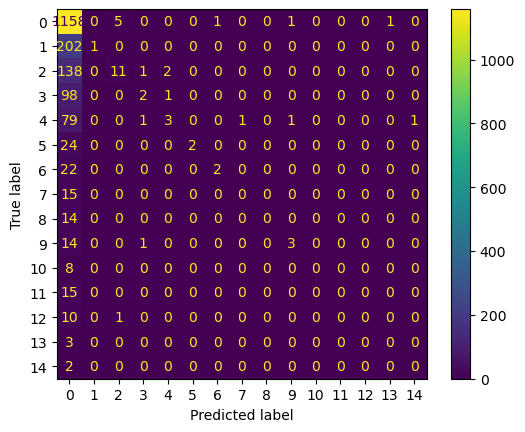

In [42]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["0", "1", "2", "3", "4","5","6","7","8","9","10","11","12","13","14"])

cm_display.plot()
plt.show()

In [43]:
def scores(clf, X_train, X_test, y_train, y_test):
    train_acc = accuracy_score(y_train, clf.predict(X_train))
    test_acc = accuracy_score(y_test, clf.predict(X_test))
    f1_macro = f1_score(y_test, clf.predict(X_test), average='macro')
    f1_micro = f1_score(y_test, clf.predict(X_test), average='micro')
    f1_weighted = f1_score(y_test, clf.predict(X_test), average='weighted')
    return train_acc, test_acc, f1_macro, f1_micro, f1_weighted

In [44]:
print("| {:25} | {} | {} | {} | {} | {} |".format("Classifier", "Training Accuracy", "Test Accuracy", "F1_macro", "F1_micro", "F1_weighted"))
print("| {} | {} | {} | {} | {} | {} |".format("-"*25, "-"*17, "-"*13, "-"*8, "-"*8, "-"*11))
clf_name = eclf_hard.__class__.__name__
train_acc, test_acc, f1_macro, f1_micro, f1_weighted  = scores(eclf_hard, x_train, x_test, y_train, y_test)
print("| {:25} | {:17.7f} | {:13.7f} | {:8.7f} | {:8.7f} | {:11.7f} |".format(clf_name, train_acc, test_acc, f1_macro, f1_micro, f1_weighted))

| Classifier                | Training Accuracy | Test Accuracy | F1_macro | F1_micro | F1_weighted |
| ------------------------- | ----------------- | ------------- | -------- | -------- | ----------- |
| VotingClassifier          |         0.9101139 |     0.6409978 | 0.1050089 | 0.6409978 |   0.5168220 |


In [126]:
#Preprocessed_texts_no_punct

In [127]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.64      0.99      0.78      1166
           1       0.50      0.00      0.01       203
           2       0.72      0.09      0.15       152
           3       0.50      0.02      0.04       101
           4       0.50      0.03      0.07        86
           5       1.00      0.08      0.14        26
           6       0.67      0.08      0.15        24
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00        14
           9       0.50      0.17      0.25        18
          10       0.00      0.00      0.00         8
          11       1.00      0.07      0.12        15
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2

    accuracy                           0.64      1844
   macro avg       0.40      0.10      0.11      1844
weighted avg       0.61   

/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


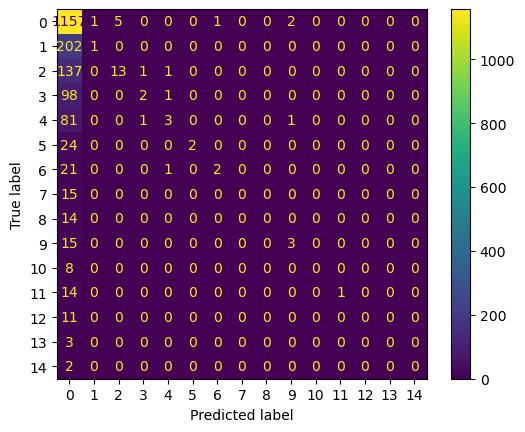

In [128]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["0", "1", "2", "3", "4","5","6","7","8","9","10","11","12","13","14"])

cm_display.plot()
plt.show()

In [129]:
print("| {:25} | {} | {} | {} | {} | {} |".format("Classifier", "Training Accuracy", "Test Accuracy", "F1_macro", "F1_micro", "F1_weighted"))
print("| {} | {} | {} | {} | {} | {} |".format("-"*25, "-"*17, "-"*13, "-"*8, "-"*8, "-"*11))
clf_name = eclf_hard.__class__.__name__
train_acc, test_acc, f1_macro, f1_micro, f1_weighted  = scores(eclf_hard, x_train, x_test, y_train, y_test)
print("| {:25} | {:17.7f} | {:13.7f} | {:8.7f} | {:8.7f} | {:11.7f} |".format(clf_name, train_acc, test_acc, f1_macro, f1_micro, f1_weighted))

| Classifier                | Training Accuracy | Test Accuracy | F1_macro | F1_micro | F1_weighted |
| ------------------------- | ----------------- | ------------- | -------- | -------- | ----------- |
| VotingClassifier          |         0.9368221 |     0.6420824 | 0.1141110 | 0.6420824 |   0.5191975 |


In [212]:
#Preprocessed_texts_lemma_em

In [213]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.64      0.99      0.78      1166
           1       0.50      0.00      0.01       203
           2       0.64      0.06      0.11       152
           3       0.29      0.02      0.04       101
           4       0.67      0.05      0.09        86
           5       1.00      0.08      0.14        26
           6       0.67      0.08      0.15        24
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00        14
           9       0.60      0.17      0.26        18
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2

    accuracy                           0.64      1844
   macro avg       0.33      0.10      0.10      1844
weighted avg       0.59   

/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


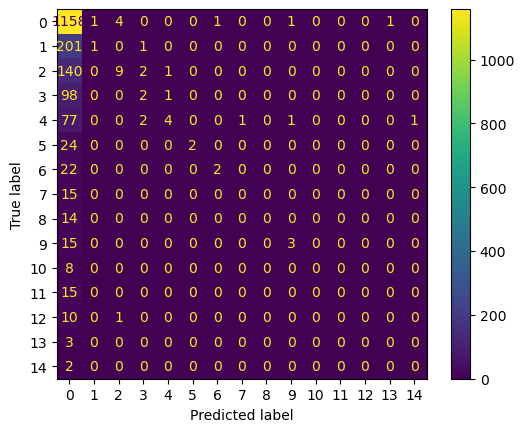

In [214]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["0", "1", "2", "3", "4","5","6","7","8","9","10","11","12","13","14"])

cm_display.plot()
plt.show()

In [215]:
print("| {:25} | {} | {} | {} | {} | {} |".format("Classifier", "Training Accuracy", "Test Accuracy", "F1_macro", "F1_micro", "F1_weighted"))
print("| {} | {} | {} | {} | {} | {} |".format("-"*25, "-"*17, "-"*13, "-"*8, "-"*8, "-"*11))
clf_name = eclf_hard.__class__.__name__
train_acc, test_acc, f1_macro, f1_micro, f1_weighted  = scores(eclf_hard, x_train, x_test, y_train, y_test)
print("| {:25} | {:17.7f} | {:13.7f} | {:8.7f} | {:8.7f} | {:11.7f} |".format(clf_name, train_acc, test_acc, f1_macro, f1_micro, f1_weighted))

| Classifier                | Training Accuracy | Test Accuracy | F1_macro | F1_micro | F1_weighted |
| ------------------------- | ----------------- | ------------- | -------- | -------- | ----------- |
| VotingClassifier          |         0.9059111 |     0.6404555 | 0.1049588 | 0.6404555 |   0.5160000 |


## Мягкое голосование

In [216]:
eclf_soft = VotingClassifier(estimators=[('lr', lr), ('svc', svc), ('rforest', rforest), ('dtree', dtree), ('nb', nb), ('gb', gb)], voting='soft')

In [217]:
eclf_soft.fit(x_train, y_train)

/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


VotingClassifier(estimators=[('lr',
                              LogisticRegression(max_iter=500,
                                                 random_state=42)),
                             ('svc', SVC(probability=True)),
                             ('rforest',
                              RandomForestClassifier(random_state=42)),
                             ('dtree', DecisionTreeClassifier()),
                             ('nb', GaussianNB()),
                             ('gb',
                              GradientBoostingClassifier(random_state=42))],
                 voting='soft')

In [218]:
predicted = eclf_soft.predict(x_test)

In [48]:
#Preprocessed_texts

In [49]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.65      0.96      0.78      1166
           1       0.14      0.01      0.03       203
           2       0.42      0.11      0.17       152
           3       0.17      0.02      0.04       101
           4       0.46      0.07      0.12        86
           5       0.67      0.08      0.14        26
           6       0.67      0.08      0.15        24
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00        14
           9       0.43      0.17      0.24        18
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2

    accuracy                           0.63      1844
   macro avg       0.24      0.10      0.11      1844
weighted avg       0.51   

/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


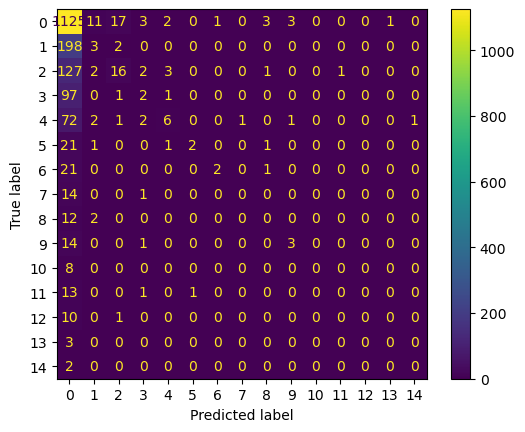

In [50]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["0", "1", "2", "3", "4","5","6","7","8","9","10","11","12","13","14"])

cm_display.plot()
plt.show()

In [51]:
print("| {:25} | {} | {} | {} | {} | {} |".format("Classifier", "Training Accuracy", "Test Accuracy", "F1_macro", "F1_micro", "F1_weighted"))
print("| {} | {} | {} | {} | {} | {} |".format("-"*25, "-"*17, "-"*13, "-"*8, "-"*8, "-"*11))
clf_name = eclf_soft.__class__.__name__
train_acc, test_acc, f1_macro, f1_micro, f1_weighted  = scores(eclf_soft, x_train, x_test, y_train, y_test)
print("| {:25} | {:17.7f} | {:13.7f} | {:8.7f} | {:8.7f} | {:11.7f} |".format(clf_name, train_acc, test_acc, f1_macro, f1_micro, f1_weighted))

| Classifier                | Training Accuracy | Test Accuracy | F1_macro | F1_micro | F1_weighted |
| ------------------------- | ----------------- | ------------- | -------- | -------- | ----------- |
| VotingClassifier          |         0.9372289 |     0.6285249 | 0.1101971 | 0.6285249 |   0.5207261 |


In [133]:
#Preprocessed_texts_no_punct

In [134]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.65      0.98      0.78      1166
           1       0.32      0.03      0.05       203
           2       0.51      0.12      0.19       152
           3       0.15      0.02      0.04       101
           4       0.38      0.03      0.06        86
           5       0.67      0.08      0.14        26
           6       1.00      0.08      0.15        24
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00        14
           9       0.50      0.17      0.25        18
          10       0.00      0.00      0.00         8
          11       0.50      0.07      0.12        15
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2

    accuracy                           0.64      1844
   macro avg       0.31      0.10      0.12      1844
weighted avg       0.54   

/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


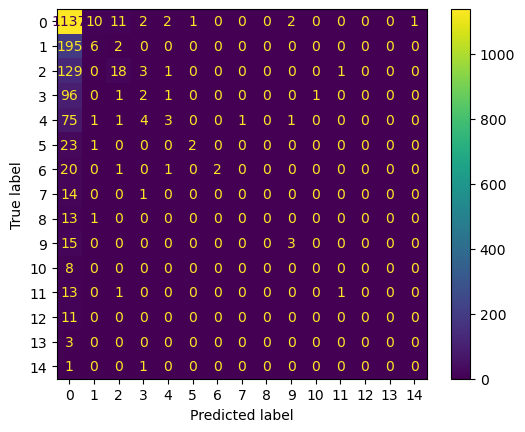

In [135]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["0", "1", "2", "3", "4","5","6","7","8","9","10","11","12","13","14"])

cm_display.plot()
plt.show()

In [136]:
print("| {:25} | {} | {} | {} | {} | {} |".format("Classifier", "Training Accuracy", "Test Accuracy", "F1_macro", "F1_micro", "F1_weighted"))
print("| {} | {} | {} | {} | {} | {} |".format("-"*25, "-"*17, "-"*13, "-"*8, "-"*8, "-"*11))
clf_name = eclf_soft.__class__.__name__
train_acc, test_acc, f1_macro, f1_micro, f1_weighted  = scores(eclf_soft, x_train, x_test, y_train, y_test)
print("| {:25} | {:17.7f} | {:13.7f} | {:8.7f} | {:8.7f} | {:11.7f} |".format(clf_name, train_acc, test_acc, f1_macro, f1_micro, f1_weighted))

| Classifier                | Training Accuracy | Test Accuracy | F1_macro | F1_micro | F1_weighted |
| ------------------------- | ----------------- | ------------- | -------- | -------- | ----------- |
| VotingClassifier          |         0.9597343 |     0.6366594 | 0.1189295 | 0.6366594 |   0.5266621 |


In [219]:
#Preprocessed_texts_lemma_em

In [220]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.65      0.96      0.77      1166
           1       0.10      0.01      0.02       203
           2       0.44      0.11      0.18       152
           3       0.14      0.02      0.03       101
           4       0.31      0.06      0.10        86
           5       0.67      0.08      0.14        26
           6       0.67      0.08      0.15        24
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00        14
           9       0.50      0.17      0.25        18
          10       0.00      0.00      0.00         8
          11       0.00      0.00      0.00        15
          12       0.00      0.00      0.00        11
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         2

    accuracy                           0.62      1844
   macro avg       0.23      0.10      0.11      1844
weighted avg       0.50   

/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


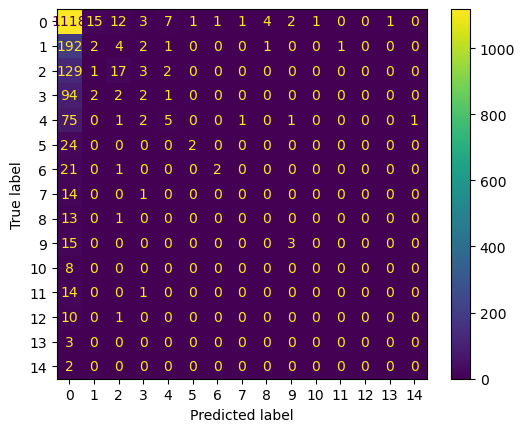

In [221]:
confusion_matrix = metrics.confusion_matrix(y_test, predicted)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["0", "1", "2", "3", "4","5","6","7","8","9","10","11","12","13","14"])

cm_display.plot()
plt.show()

In [222]:
print("| {:25} | {} | {} | {} | {} | {} |".format("Classifier", "Training Accuracy", "Test Accuracy", "F1_macro", "F1_micro", "F1_weighted"))
print("| {} | {} | {} | {} | {} | {} |".format("-"*25, "-"*17, "-"*13, "-"*8, "-"*8, "-"*11))
clf_name = eclf_soft.__class__.__name__
train_acc, test_acc, f1_macro, f1_micro, f1_weighted  = scores(eclf_soft, x_train, x_test, y_train, y_test)
print("| {:25} | {:17.7f} | {:13.7f} | {:8.7f} | {:8.7f} | {:11.7f} |".format(clf_name, train_acc, test_acc, f1_macro, f1_micro, f1_weighted))

| Classifier                | Training Accuracy | Test Accuracy | F1_macro | F1_micro | F1_weighted |
| ------------------------- | ----------------- | ------------- | -------- | -------- | ----------- |
| VotingClassifier          |         0.9360087 |     0.6241866 | 0.1090944 | 0.6241866 |   0.5173165 |


## Обучаем модели машинного обучения

In [53]:
#Preprocessed_texts

In [54]:
# train and test them 
print("| {:25} | {} | {} | {} | {} | {} |".format("Classifier", "Training Accuracy", "Test Accuracy", "F1_macro", "F1_micro", "F1_weighted"))
print("| {} | {} | {} | {} | {} | {} |".format("-"*25, "-"*17, "-"*13, "-"*8, "-"*8, "-"*11))
for clf in clifs: 
    clf_name = clf.__class__.__name__
    train_acc, test_acc, f1_macro, f1_micro, f1_weighted  = train_test(clf, x_train, x_test, y_train, y_test)
    print("| {:25} | {:17.7f} | {:13.7f} | {:8.7f} | {:8.7f} | {:11.7f} |".format(clf_name, train_acc, test_acc, f1_macro, f1_micro, f1_weighted))

| Classifier                | Training Accuracy | Test Accuracy | F1_macro | F1_micro | F1_weighted |
| ------------------------- | ----------------- | ------------- | -------- | -------- | ----------- |


/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| LogisticRegression        |         0.9025217 |     0.5276573 | 0.1130856 | 0.5276573 |   0.4950836 |
| SVC                       |         0.7007863 |     0.6377440 | 0.0678464 | 0.6377440 |   0.5025198 |
| RandomForestClassifier    |         0.9632592 |     0.6372017 | 0.1102073 | 0.6372017 |   0.5174832 |
| DecisionTreeClassifier    |         0.9632592 |     0.4734273 | 0.1021337 | 0.4734273 |   0.4640743 |
| GaussianNB                |         0.0389100 |     0.0330803 | 0.0115141 | 0.0330803 |   0.0434178 |
| GradientBoostingClassifier |         0.7777928 |     0.5862256 | 0.0819257 | 0.5862256 |   0.4924734 |


In [138]:
#Preprocessed_texts_no_punct

In [139]:
print("| {:25} | {} | {} | {} | {} | {} |".format("Classifier", "Training Accuracy", "Test Accuracy", "F1_macro", "F1_micro", "F1_weighted"))
print("| {} | {} | {} | {} | {} | {} |".format("-"*25, "-"*17, "-"*13, "-"*8, "-"*8, "-"*11))
for clf in clifs: 
    clf_name = clf.__class__.__name__
    train_acc, test_acc, f1_macro, f1_micro, f1_weighted  = train_test(clf, x_train, x_test, y_train, y_test)
    print("| {:25} | {:17.7f} | {:13.7f} | {:8.7f} | {:8.7f} | {:11.7f} |".format(clf_name, train_acc, test_acc, f1_macro, f1_micro, f1_weighted))

| Classifier                | Training Accuracy | Test Accuracy | F1_macro | F1_micro | F1_weighted |
| ------------------------- | ----------------- | ------------- | -------- | -------- | ----------- |
| LogisticRegression        |         0.9295011 |     0.5271150 | 0.1228389 | 0.5271150 |   0.5046923 |
| SVC                       |         0.7052603 |     0.6382863 | 0.0767339 | 0.6382863 |   0.5036190 |
| RandomForestClassifier    |         0.9814262 |     0.6393709 | 0.1056661 | 0.6393709 |   0.5180271 |
| DecisionTreeClassifier    |         0.9814262 |     0.4436009 | 0.1063360 | 0.4436009 |   0.4440960 |
| GaussianNB                |         0.0123373 |     0.0103037 | 0.0104955 | 0.0103037 |   0.0105095 |
| GradientBoostingClassifier |         0.7933839 |     0.5851410 | 0.0912319 | 0.5851410 |   0.4962020 |


In [224]:
#Preprocessed_texts_lemma

In [225]:
print("| {:25} | {} | {} | {} | {} | {} |".format("Classifier", "Training Accuracy", "Test Accuracy", "F1_macro", "F1_micro", "F1_weighted"))
print("| {} | {} | {} | {} | {} | {} |".format("-"*25, "-"*17, "-"*13, "-"*8, "-"*8, "-"*11))
for clf in clifs: 
    clf_name = clf.__class__.__name__
    train_acc, test_acc, f1_macro, f1_micro, f1_weighted  = train_test(clf, x_train, x_test, y_train, y_test)
    print("| {:25} | {:17.7f} | {:13.7f} | {:8.7f} | {:8.7f} | {:11.7f} |".format(clf_name, train_acc, test_acc, f1_macro, f1_micro, f1_weighted))

| Classifier                | Training Accuracy | Test Accuracy | F1_macro | F1_micro | F1_weighted |
| ------------------------- | ----------------- | ------------- | -------- | -------- | ----------- |


/Users/kholann/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


| LogisticRegression        |         0.8973698 |     0.5206074 | 0.1138981 | 0.5206074 |   0.4915423 |
| SVC                       |         0.6990239 |     0.6366594 | 0.0659109 | 0.6366594 |   0.5003874 |
| RandomForestClassifier    |         0.9616323 |     0.6366594 | 0.1114342 | 0.6366594 |   0.5198198 |
| DecisionTreeClassifier    |         0.9616323 |     0.4620390 | 0.0988861 | 0.4620390 |   0.4618186 |
| GaussianNB                |         0.0399946 |     0.0352495 | 0.0114393 | 0.0352495 |   0.0483441 |
| GradientBoostingClassifier |         0.7802332 |     0.5900217 | 0.0735431 | 0.5900217 |   0.4919768 |


## Оцениваем качество обучения на тестовом наборе данных

Определяем долю правильных ответов (accuracy) на тестовом наборе данных

In [226]:
#Preprocessed_texts_no_punct_lemma_em

In [230]:
# max_len = 11 df_em_1_token_10 9220 записей c clean_text
# 0.5558568329718004 на тексте как есть с пунктуацией и с эмодзи
# 0.5374186550976139 на тексте без пунктуации и без эмодзи
# 0.5482646420824295 лемматизированный текст с пунктуацией и с эмодзи

In [231]:
# df_em_1_token_10 9220 записей c clean_text
# на тексте как есть с пунктуацией и с эмодзи

# f1_score macro  = 0.12202621635120255
# f1_score micro = 0.5558568329718004
# f1_score weighted = 0.5221240288457648
# f1_score average=None 
# array([0.72926448, 0.18362283, 0.21276596, 0.13664596, 0.15254237,
#       0.04878049, 0.        , 0.        , 0.09090909, 0.27586207,
#       0.        , 0.        , 0.        , 0.        , 0.        ])

# на тексте без пунктуации и без эмодзи
# f1_score macro  = 0.10644965939153658
# f1_score micro = 0.5374186550976139
# f1_score weighted = 0.5176721628807247
# f1_score average = None 
# array([0.7152    , 0.12244898, 0.31012658, 0.15217391, 0.10526316,
 #      0.0625    , 0.        , 0.        , 0.        , 0.12903226,
 #      0.        , 0.        , 0.        , 0.        , 0.        ])

# лемматизированный текст c пунктуацией и с эмодзи
# f1_score macro  = 0.10655596088859548
# f1_score micro = 0.5482646420824295
# f1_score weighted = 0.5206993167971358
# f1_score average = None 
# array([0.72459271, 0.14689266, 0.20074349, 0.08839779, 0.17021277,
 #      0.        , 0.        , 0.08      , 0.        , 0.1875    ,
  #     0.        , 0.        , 0.        , 0.        , 0.        ])

## Применяем модель

In [232]:
#text = "Хех и сразу музыка в голове"
#text = "я даже неделю не могу продержаться 😭"
text = "жизнь прекрасна!"

Подготовка текста к обработке

In [233]:
preprocessed_text = preprocess_lemma_em(text)

In [234]:
preprocessed_text

['жизнь', 'прекрасна!']

In [235]:
vectorized_text = vectorize_text(preprocessed_text, navec, max_len)

In [236]:
vectorized_text

[array([-2.73285210e-02, -1.94620594e-01, -1.69510201e-01, -1.58291608e-01,
         2.47969598e-01,  2.37294197e-01, -4.67231087e-02, -3.75020593e-01,
        -3.06117833e-01,  8.46114848e-03, -1.93853632e-01, -3.08562636e-01,
        -2.79389858e-01,  2.25109398e-01, -3.01646143e-01,  3.60722095e-01,
        -4.42994386e-02,  2.28967205e-01,  2.35490263e-01, -2.85830677e-01,
        -8.45961496e-02, -3.72325256e-02, -1.20135747e-01,  6.15459442e-01,
         1.14343882e-01, -1.42356688e-02,  4.27563071e-01,  4.53989267e-01,
         1.53825536e-01,  2.31566623e-01, -5.44217825e-01,  2.07250446e-01,
         7.30184078e-01, -7.47062936e-02,  2.22465709e-01,  2.62596607e-01,
         1.95609435e-01, -5.55571131e-02,  5.99178970e-01,  6.55301437e-02,
        -1.41489888e-02,  1.39325052e-01,  3.17966014e-01, -5.35112381e-01,
        -8.62428844e-02, -6.34264573e-02,  2.22086702e-02,  1.98050618e-01,
         1.21000493e-02, -4.33144569e-01,  4.00262326e-01, -9.74982511e-03,
        -5.6

In [237]:
_vector = np.array(vectorized_text).reshape(1, vector_size * max_len)

In [238]:
_vector.shape

(1, 3300)

Выполняем распознавание

In [239]:
# Мажоритарное голосование

In [240]:
result = eclf_hard.predict(_vector)

In [241]:
result, emoji_dict[str(result[0])]

(array([0]), 'smile positive/negative')

In [242]:
# Мягкое голосование

In [243]:
result = eclf_soft.predict(_vector)

In [244]:
result, emoji_dict[str(result[0])]

(array([0]), 'smile positive/negative')

In [245]:
result_clf = []
for clf in clifs:
    result_clf.append(clf.predict(_vector))

In [246]:
result_clf

[array([0]), array([0]), array([0]), array([1]), array([8]), array([0])]

In [247]:
for i in range(0, len(result_clf)):
    res = result_clf[i][0]
    print(res, emoji_dict[str(res)])

0 smile positive/negative
0 smile positive/negative
0 smile positive/negative
1 no_emotion neutral/skeptical
8 disgust negative
0 smile positive/negative


In [248]:
# Мажоритарное голосование

In [249]:
result = eclf_hard.predict_proba(_vector)

AttributeError: predict_proba is not available when voting='hard'

In [250]:
# Мягкое голосование

In [251]:
result = eclf_soft.predict_proba(_vector)

In [252]:
result

array([[5.24693681e-01, 1.90250682e-01, 4.70312827e-02, 2.70548082e-02,
        1.73003487e-02, 4.40897951e-03, 7.44400812e-03, 1.56733859e-03,
        1.70152847e-01, 5.22320617e-03, 1.88509604e-03, 2.07356758e-03,
        4.21878896e-04, 3.83402507e-04, 1.08873685e-04]])

In [253]:
i = 0
while i < len(result[0]):
    print(str(i) +": "+ emoji_dict[str(i)], round(result[0][i], 3))
    i += 1

0: smile positive/negative 0.525
1: no_emotion neutral/skeptical 0.19
2: joy positive 0.047
3: no_emotion positive/negative 0.027
4: sadness negative 0.017
5: fear negative 0.004
6: shame negative 0.007
7: anger negative 0.002
8: disgust negative 0.17
9: surprise positive/negative 0.005
10: disgust neutral/skeptical 0.002
11: surprise negative 0.002
12: no_emotion negative 0.0
13: sadness positive/negative 0.0
14: fear positive/negative 0.0


In [254]:
# LogisticRegression       
# SVC                       
# RandomForestClassifier    
# DecisionTreeClassifier    
# GaussianNB               
# GradientBoostingClassifier

In [255]:
#result = []
for clf in clifs:
    try:
        result = clf.predict_proba(_vector)
        print(clf.__class__.__name__ + ":")
        i = 0
        while i < len(result[0]):
            print(str(i) +": "+ emoji_dict[str(i)], round(result[0][i], 3))
            i += 1
    except:
        print(clf.__class__.__name__)
        print("No predict_proba")

LogisticRegression:
0: smile positive/negative 0.613
1: no_emotion neutral/skeptical 0.274
2: joy positive 0.088
3: no_emotion positive/negative 0.004
4: sadness negative 0.012
5: fear negative 0.001
6: shame negative 0.004
7: anger negative 0.0
8: disgust negative 0.001
9: surprise positive/negative 0.003
10: disgust neutral/skeptical 0.0
11: surprise negative 0.0
12: no_emotion negative 0.0
13: sadness positive/negative 0.001
14: fear positive/negative 0.0
SVC:
0: smile positive/negative 0.72
1: no_emotion neutral/skeptical 0.135
2: joy positive 0.035
3: no_emotion positive/negative 0.033
4: sadness negative 0.032
5: fear negative 0.006
6: shame negative 0.012
7: anger negative 0.005
8: disgust negative 0.007
9: surprise positive/negative 0.005
10: disgust neutral/skeptical 0.002
11: surprise negative 0.002
12: no_emotion negative 0.002
13: sadness positive/negative 0.002
14: fear positive/negative 0.001
RandomForestClassifier:
0: smile positive/negative 0.638
1: no_emotion neutral/s